In [11]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve

In [12]:
ped_file = '../../DATA/spark/spark.ped'
phase_dir = '../phased_spark_del'
assembly = '38'

#ped_file = '../../DATA/ihart.v34/ihart.ped'
#phase_dir = '../phased_ihart.v34_del'
#assembly = '19'

In [13]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            #if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                #child_id = ssc_old_id_to_new_id[child_id]
                #f_id = ssc_old_id_to_new_id[f_id]
                #m_id = ssc_old_id_to_new_id[m_id]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if f_id != '0' and m_id != '0':
                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 81355


In [14]:
with open('%s/Xdeletions.json' % phase_dir) as f:
    deletions = json.load(f)

In [16]:
# filter deletions
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

chroms = [str(x) for x in range(1, 23)]
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)


with open('../data/filtered_regions_hg%s.bed' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in ['X']:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
full_deletions = [d for i, d in enumerate(deletions) if i not in excluded_deletions]
print('remaining deletions', len(deletions))

remaining deletions 17697
remaining deletions 17697
excluded deletions 0
remaining deletions 17697


In [17]:
deletions = []
fam_to_num_bases = defaultdict(int)
fam_to_num_dels = defaultdict(int)
fam_to_size = dict([(x[0], len(v)) for x, v in fam_to_inds.items()])

for d in full_deletions:
    if d['is_inherited'] and d['family_size']>=4 and fam_to_size[d['family']] == d['family_size']:
        for child in d['trans']:
            #if child_id_to_sex[child]=='1':
            deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        assert fam_to_size[d['family']] == d['family_size']
                
        fam_to_num_bases[d['family']] += d['length']
        fam_to_num_dels[d['family']] += 1

In [18]:
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))

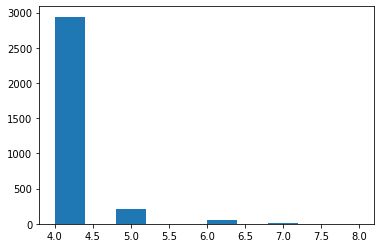

In [19]:
plt.hist([fam_to_size[x] for x in families])
plt.show()

In [20]:
with open('%s/individuals.json' % phase_dir) as f:
    individuals = set(json.load(f))
    
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))
    
children = set()
for fam, inds in fam_to_inds.items():
    #print(fam, inds)
    if fam[0] in families and len(inds)>3:
        children.update([x for x in inds[2:] if x in individuals])
    
assert np.all(x in in_ped for x in individuals)
child_to_index = dict([(x, i) for i, x in enumerate(children)])

print(len(individuals), len(children))

13175 6721


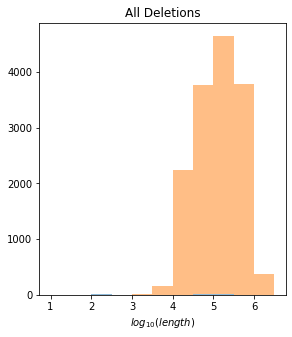

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist([[np.log10(d['length']) for d in deletions if d['is_mat']],
                        [np.log10(d['length']) for d in deletions if d['is_pat']]], 
                       stacked=True, bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')


plt.show()

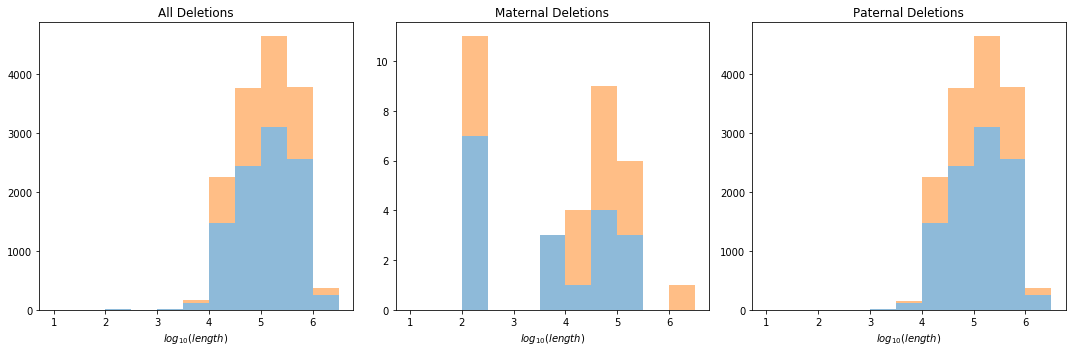

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist([[np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2'],
          [np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1']], 
         bins=np.arange(1, 7, 0.5), alpha=0.5, stacked=True)
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 2)
plt.hist([[np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_mat']],
          [np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_mat']]], 
         bins=np.arange(1, 7, 0.5), alpha=0.5, stacked=True)
plt.title('Maternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 3)
plt.hist([[np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_pat']],
          [np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_pat']]], 
         bins=np.arange(1, 7, 0.5), alpha=0.5, stacked=True)
plt.title('Paternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.tight_layout()
plt.show()

In [31]:
num_deletions = np.zeros((len(children),))
mat_num_deletions = np.zeros((len(children),))
pat_num_deletions = np.zeros((len(children),))

num_bases = np.zeros((len(children),))
mat_num_bases =np.zeros((len(children),))
pat_num_bases = np.zeros((len(children),))

for d in deletions:
    child_index = child_to_index[d['child']]
    num_deletions[child_index] += 1
    num_bases[child_index] += d['length']
    if d['is_mat']:
        mat_num_deletions[child_index] += 1
        mat_num_bases[child_index] += d['length']
    if d['is_pat']:
        pat_num_deletions[child_index] += 1
        pat_num_bases[child_index] += d['length']


In [32]:
is_aut = np.array([child_id_to_affected[x]=='2' for x in children])
is_nt = np.array([child_id_to_affected[x]=='1' for x in children])

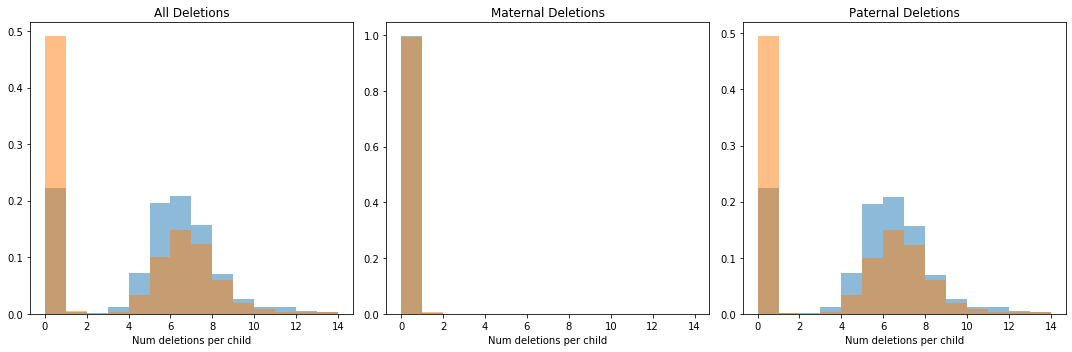

In [38]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 15)
max_clip = 14

plt.subplot(1, 3, 1)
plt.hist(np.clip(num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(1, 3, 2)
plt.hist(np.clip(mat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(mat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(1, 3, 3)
plt.hist(np.clip(pat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(pat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num deletions per child')


plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


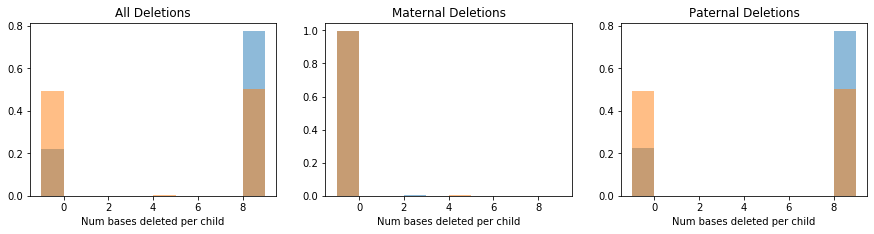

In [40]:
plt.figure(figsize=(15, 7))

bins = np.arange(-1, 10, 1)

plt.subplot(2, 3, 1)
plt.hist(np.clip(np.log10(num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 2)
plt.hist(np.clip(np.log10(mat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(mat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 3)
plt.hist(np.clip(np.log10(pat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(pat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num bases deleted per child')

plt.show()

In [41]:
print(np.sum(is_aut), np.sum(is_nt))

3861 2860


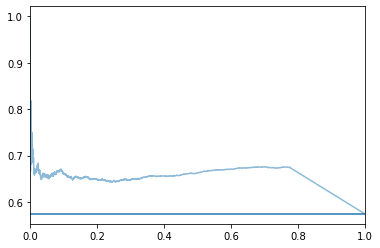

In [42]:
precision, recall, _ = precision_recall_curve(is_aut, num_bases)
plt.plot(recall, precision, alpha=0.5)
plt.axhline(np.sum(is_aut)/len(children))
plt.xlim([0, 1])
plt.show()

In [45]:
children_phens = []
in_children_phen = set()

for fam, inds in fam_to_inds.items():
    fam_children = [x for x in inds[2:] if x in individuals]
    if len(fam_children)>0:
        phens = [child_id_to_affected[x] for x in fam_children]
        random.shuffle(phens)
        children_phens.append((fam_children, phens))
        in_children_phen.update(fam_children)
        
print(len(children_phens))

3227


In [47]:
assert np.all([x['child'] in in_children_phen and (x['child'] in children) for x in deletions])


In [48]:
print(len([d for d in deletions if d['is_mat']]))
print(len([d for d in deletions if d['is_pat']]))

34
27854


In [51]:
# do autistic children inherit more deletions from mom vs dad than their NT peers?

# Python
def calc_pvalue_hypergeom(c):
    return stats.hypergeom(M=np.sum(c), n=c[0][0]+c[0][1], N=c[0][0]+c[1][0]).sf(c[0][0]-1)

In [54]:
# result could be due to family size, so try a permutation test
num_permutations = 1000

del_is_mat = np.array([x['is_mat'] for x in deletions])
del_is_pat = np.array([x['is_pat'] for x in deletions])
del_is_f = np.array([child_id_to_sex[x['child']]=='2' for x in deletions])
del_is_m = np.array([child_id_to_sex[x['child']]=='1' for x in deletions])

def calculate_pvalues(aff):
    del_is_aff = np.array([(aff[x['child']]=='2') for x in deletions])
    del_is_unaff = np.array([(aff[x['child']]=='1') for x in deletions])


    pvalue = calc_pvalue_hypergeom([[np.sum(del_is_aff & del_is_mat), 
                                      np.sum(del_is_unaff & del_is_mat)], 
                                     [np.sum(del_is_aff & del_is_pat), 
                                      np.sum(del_is_unaff & del_is_pat)]])
    
        
    mat_pvalue = calc_pvalue_hypergeom([[np.sum(del_is_f & del_is_aff & del_is_mat), 
                                          np.sum(del_is_f & del_is_unaff & del_is_mat)], 
                                         [np.sum(del_is_f & del_is_aff & del_is_pat), 
                                          np.sum(del_is_f & del_is_unaff & del_is_pat)]])
    
    pat_pvalue = calc_pvalue_hypergeom([[np.sum(del_is_m & del_is_aff & del_is_mat), 
                                          np.sum(del_is_m & del_is_unaff & del_is_mat)], 
                                         [np.sum(del_is_m & del_is_aff & del_is_pat), 
                                          np.sum(del_is_m & del_is_unaff & del_is_pat)]])
    
    return pvalue, mat_pvalue, pat_pvalue
    
pp = np.ones((num_permutations,))
pp_mat = np.ones((num_permutations,))
pp_pat = np.ones((num_permutations,))

for j in range(num_permutations):
    new_child_id_to_affected = dict()
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        new_child_id_to_affected.update(list(zip(fam_children, phens)))
            
    pp[j], pp_mat[j], pp_pat[j] = calculate_pvalues(new_child_id_to_affected)
        
            
    if j%100==0:
        print(j, end=' ')
    
        

0 100 200 300 400 500 600 700 800 900 

In [55]:
pvalue, mat_pvalue, pat_pvalue = calculate_pvalues(child_id_to_affected)

print(np.sum(pp<=pvalue)/np.sum(~np.isnan(pp)))
print(np.sum(pp_mat<=mat_pvalue)/np.sum(~np.isnan(pp_mat)))
print(np.sum(pp_pat<=pat_pvalue)/np.sum(~np.isnan(pp_pat)))
        

1.0
0.998
0.487


In [ ]:
# Look at 

# Create matrix for GLRM 

In [ ]:
print(len(children))

In [ ]:
del_matrices = []
del_matrices_ismat = []
del_matrices_ispat = []

for chrom in ['X']:
    chrom_deletions = [d for d in deletions if d['chrom']==chrom]
    chrom_notrans_deletions = [d for d in notrans_deletions if d['chrom']==chrom]
    
    endpoints = [d['start_pos'] for d in chrom_deletions] 
    endpoints += [d['start_pos']-1 for d in chrom_deletions]
    endpoints += [d['end_pos'] for d in chrom_deletions]
    endpoints += [d['end_pos']-1 for d in chrom_deletions]
    endpoints += [d['start_pos'] for d in chrom_notrans_deletions] 
    endpoints += [d['start_pos']-1 for d in chrom_notrans_deletions]
    endpoints += [d['end_pos'] for d in chrom_notrans_deletions]
    endpoints += [d['end_pos']-1 for d in chrom_notrans_deletions]
    endpoints = sorted(set(endpoints))
    endpoint_to_index = dict([(x, i) for i, x in enumerate(endpoints)])
    
    del_matrix = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        del_matrix[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        del_matrix[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices.append(del_matrix)
    
    del_matrix_ismat = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        if d['is_mat']:
            del_matrix_ismat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        if d['is_mat']:
            del_matrix_ismat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices_ismat.append(del_matrix_ismat)
    
    del_matrix_ispat = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        if d['is_pat']:
            del_matrix_ispat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        if d['is_pat']:
            del_matrix_ispat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices_ispat.append(del_matrix_ispat)
    
del_matrix = np.hstack(del_matrices)
del_matrix_ismat = np.hstack(del_matrices_ismat)
del_matrix_ispat = np.hstack(del_matrices_ispat)
print(del_matrix.shape)

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(del_matrix_ismat, aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(del_matrix_ispat, aspect='auto')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(np.clip(np.sum((del_matrix==1), axis=0), None, 100), log=True, bins=np.arange(0, 200, 1), alpha=0.5)
plt.hist(np.clip(np.sum((del_matrix==-1), axis=0), None, 100), log=True, bins=np.arange(0, 200, 1), alpha=0.5)
plt.show()

# Predict ASD

In [ ]:
X = np.unique(del_matrix, axis=1)
X = X[:, np.sum(X==1, axis=0)>5]
print(X.shape)

X_ismat = np.unique(del_matrix_ismat, axis=1)
X_ismat = X_ismat[:, np.sum(X_ismat==1, axis=0)>5]
print(X_ismat.shape)

X_ispat = np.unique(del_matrix_ispat, axis=1)
X_ispat = X_ispat[:, np.sum(X_ispat==1, axis=0)>5]
print(X_ispat.shape)

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(X_ismat, aspect='auto')
plt.show()

In [ ]:
y = np.array([child_id_to_affected[x]=='2' for x in children])

In [ ]:
# try a permutation test

num_permutations = 1000

permute_pvalues = np.ones((X.shape[1], num_permutations))
permute_pvalues_mat = np.ones((X_ismat.shape[1], num_permutations))
permute_pvalues_pat = np.ones((X_ispat.shape[1], num_permutations))

def calculate_pvalues(y):
    c = np.array([[np.sum(X[y, :]==1, axis=0), 
                                      np.sum(X[~y, :]==1, axis=0)], 
                                     [np.sum(X[y, :]==-1, axis=0), 
                                      np.sum(X[~y, :]==-1, axis=0)]])
    pvalues = np.ones((X.shape[1],))
    for i in range(X.shape[1]):
        try:
            pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
        
    c = np.array([[np.sum(X[y, :]==1, axis=0), 
                                      np.sum(X_ismat[~y, :]==1, axis=0)], 
                                     [np.sum(X_ismat[y, :]==-1, axis=0), 
                                      np.sum(X_ismat[~y, :]==-1, axis=0)]])
    mat_pvalues = np.ones((X_ismat.shape[1],))
    for i in range(X_ismat.shape[1]):
        try:
            mat_pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
        
    c = np.array([[np.sum(X_ispat[y, :]==1, axis=0), 
                                      np.sum(X_ispat[~y, :]==1, axis=0)], 
                                     [np.sum(X_ispat[y, :]==-1, axis=0), 
                                      np.sum(X_ispat[~y, :]==-1, axis=0)]])
    
    pat_pvalues = np.ones((X_ispat.shape[1],))
    for i in range(X_ispat.shape[1]):
        try:
            pat_pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
    
    return pvalues, mat_pvalues, pat_pvalues
    
permute_y = np.zeros((len(children),), dtype=bool)
for j in range(num_permutations):
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        for child, new_phen in zip(fam_children, phens):
            permute_y[child_to_index[child]] = (new_phen=='2')
            
    permute_pvalues[:, j], permute_pvalues_mat[:, j], permute_pvalues_pat[:, j] = calculate_pvalues(permute_y)
        
            
    if j%100==0:
        print(j, end=' ')
    
        

In [ ]:
unadj_pvalues, unadj_pvalues_mat, unadj_pvalues_pat = calculate_pvalues(y)
indices = np.argsort(unadj_pvalues)
indices_mat = np.argsort(unadj_pvalues_mat)
indices_pat = np.argsort(unadj_pvalues_pat)

pi = np.ones((X.shape[1], 3))

min_pvalues = np.min(permute_pvalues, axis=0)
min_pvalues_mat = np.min(permute_pvalues_mat, axis=0)
min_pvalues_pat = np.min(permute_pvalues_pat, axis=0)
pi[0, 0] = np.sum(min_pvalues <= unadj_pvalues[indices[0]])/num_permutations
pi[0, 1] = np.sum(min_pvalues_mat <= unadj_pvalues_mat[indices_mat[0]])/num_permutations
pi[0, 2] = np.sum(min_pvalues_pat <= unadj_pvalues_pat[indices_pat[0]])/num_permutations
for i in range(1, 20):
    min_pvalues = np.min(permute_pvalues[indices>=i, :], axis=0)
    min_pvalues_mat = np.min(permute_pvalues_mat[indices_mat>=i, :], axis=0)
    min_pvalues_pat = np.min(permute_pvalues_pat[indices_pat>=i, :], axis=0)
    pi[i, 0] = max(pi[i-1, 0], np.sum(min_pvalues <= unadj_pvalues[indices[i]])/num_permutations)
    pi[i, 1] = max(pi[i-1, 1], np.sum(min_pvalues_mat <= unadj_pvalues_mat[indices_mat[i]])/num_permutations)
    pi[i, 2] = max(pi[i-1, 2], np.sum(min_pvalues_pat <= unadj_pvalues_pat[indices_pat[i]])/num_permutations)
    
    if i%10==0:
        print(i, '/', 20)


In [ ]:
print(pi[:20])

In [ ]:
pvalues = np.ones((X.shape[1],))

perm_pvalues = np.ones((X.shape[1],))
for i in range(X.shape[1]):
    perm_pvalues[i] = np.sum(permute_pvalues[i, :]<=unadj_pvalues[i])/num_permutations
    

    
plt.hist(-np.log10(perm_pvalues), alpha=0.5, bins=np.arange(0.1, 3, 0.1))
#plt.hist(-np.log10(unadj_pvalues), alpha=0.5, bins=np.arange(0, 3, 0.1))
plt.axvline(-np.log10(0.05), color='black', linestyle='--')
plt.show()

# try GLRM using G + P

In [ ]:
phen_data = np.zeros((len(children), 40))
with open('../phenotypes/spark/scq.csv', 'r') as f:
    header = next(f).split(',')
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] in child_to_index:
            child_index = child_to_index[pieces[0]]
            phen_data[child_index, :] = [1 if x=='1' else -1 if x=='0' else 0 for x in pieces[11:51]]

In [ ]:
phen_data[phen_data==0] = np.nan

In [ ]:
from pyglrm import glrm, observations
g = glrm(n_components=2)
g.fit_impute(A)
g.get_hyperprams()